In [1]:
import tensorflow as tf
from tensorflow import keras

import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_path = "./dataset/main_directory/"
test_path = "./dataset/test/"

INPUT_SHAPE = (224,224,3)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
def parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img,INPUT_SHAPE[:2])
    return img

def make_dataset(filepaths):
    filenames_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filenames_ds.map(
        parse_image,
        num_parallel_calls=AUTOTUNE
    )
    return images_ds

def configure_for_performance(ds):
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [4]:
filenames = os.listdir(test_path)
num_test = len(filenames)
print("number of test samples :", num_test)

filepaths = []
for filename in filenames:
    filepaths.append(os.path.join(test_path+filename))
print(filepaths[:5])

number of test samples : 215
['./dataset/test/001.png', './dataset/test/002.png', './dataset/test/003.png', './dataset/test/004.png', './dataset/test/005.png']


In [5]:
test_ds = make_dataset(filepaths=filepaths)

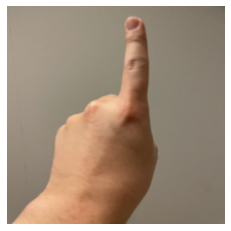

In [6]:
for img in test_ds.take(1):
    img = (img.numpy())
    img = img.astype(np.uint8)
    plt.imshow(img), plt.axis('off')
    plt.show()

In [7]:
test_ds = configure_for_performance(test_ds)

In [8]:
type(test_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [9]:
test_ds.element_spec

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)

In [10]:
model_list = glob('./model/*.h5')
model_list[-5:]

['./model\\008-0.5556.h5',
 './model\\012-0.5029.h5',
 './model\\021-0.4691.h5',
 './model\\034-0.4512.h5',
 './model\\059-0.3974.h5']

In [11]:
model = keras.models.load_model(model_list[-1])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_2 (Dropout)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 2000)              200706000 
                                                                 
 dropout_3 (Dropout)         (None, 2000)             

In [12]:
test_confidence = model.predict(test_ds)

In [13]:
classes = os.listdir(train_path)
num_classes = len(classes)
print("number of classes :", num_classes)

number of classes : 11


In [14]:
test_classes = []
for confidence in test_confidence:
    label = confidence.argmax()
    test_classes.append(classes[label])

In [15]:
len(test_classes)

215

In [16]:
with open("./result/dropout2.csv",'w',encoding='utf8') as f:
    f.write('file_name,label\n')
    for i in range(num_test):
        f.write('{},{}\n'.format(filenames[i],test_classes[i]))